# Combining Python and R

The [rpy2][rpy2] library allows Python to interface directly with R by passing Python objects into R functions and converting the R output back into Python objects. It also comes with a few [Jupyter magic commands][rmagic] for interactively exploring data with R in a Python notebook. 

In this notebook, we'll see how to use those magic commands, and to do so we must first load the `rpy2` Jupyter extension with the `load_ext` magic command. 

[rpy2]: https://rpy2.bitbucket.io/
[rmagic]: http://rpy.sourceforge.net/rpy2/doc-dev/html/interactive.html#module-rpy2.ipython.rmagic

In [1]:
%load_ext rpy2.ipython

The `rpy2` library is set up to interact with pandas `DataFrame` objects, so we'll need to import the pandas library. Then, we'll import a sample dataset from scikit-learn to play around with. The scikit-learn datasets are imported not as `DataFrame` objects, but as dictionary-like objects called `Bunch`es. Unfortunately, these `Bunch` objects do not work with `rpy2`, so we'll need to extract the data from the `Bunch` object to create a corresponding `DataFrame` object that can be passed to R.

In [2]:
import pandas as pd
from sklearn import datasets

# Load the Boston housing dataset and create a DataFrame from the data
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target

On a side note, though these `Bunch` objects don't work directly with `rpy2`, they still have one pretty nice feature. Just like R's data packages, they come with a bit of documentation built in. To see it, just print the `DESCR` attribute.

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Next, we'll create a visualization of our housing data by passing the data frame we created above into R and making use of the [ggplot2][ggplot2] library. We'll plot the distance to employment centers against the crime rate and see what turns up.

To do this, we'll need to make use of a few of the `%%R` magic command's parameters. Specifically, we'll use the `-i` parameter to specify the `DataFrame` object that we need `rpy2` to convert to the R equivalent. We'll also set a few parameters that control the size and resolution of the resultant visualization---for more information on why we're setting these variables, read over the notebook titled [Resolution Setup][res_setup] to see why we chose the the settings below.

[ggplot2]: http://ggplot2.tidyverse.org/
[res_setup]: http://localhost:8888/notebooks/Resolution%20Setup.ipynb

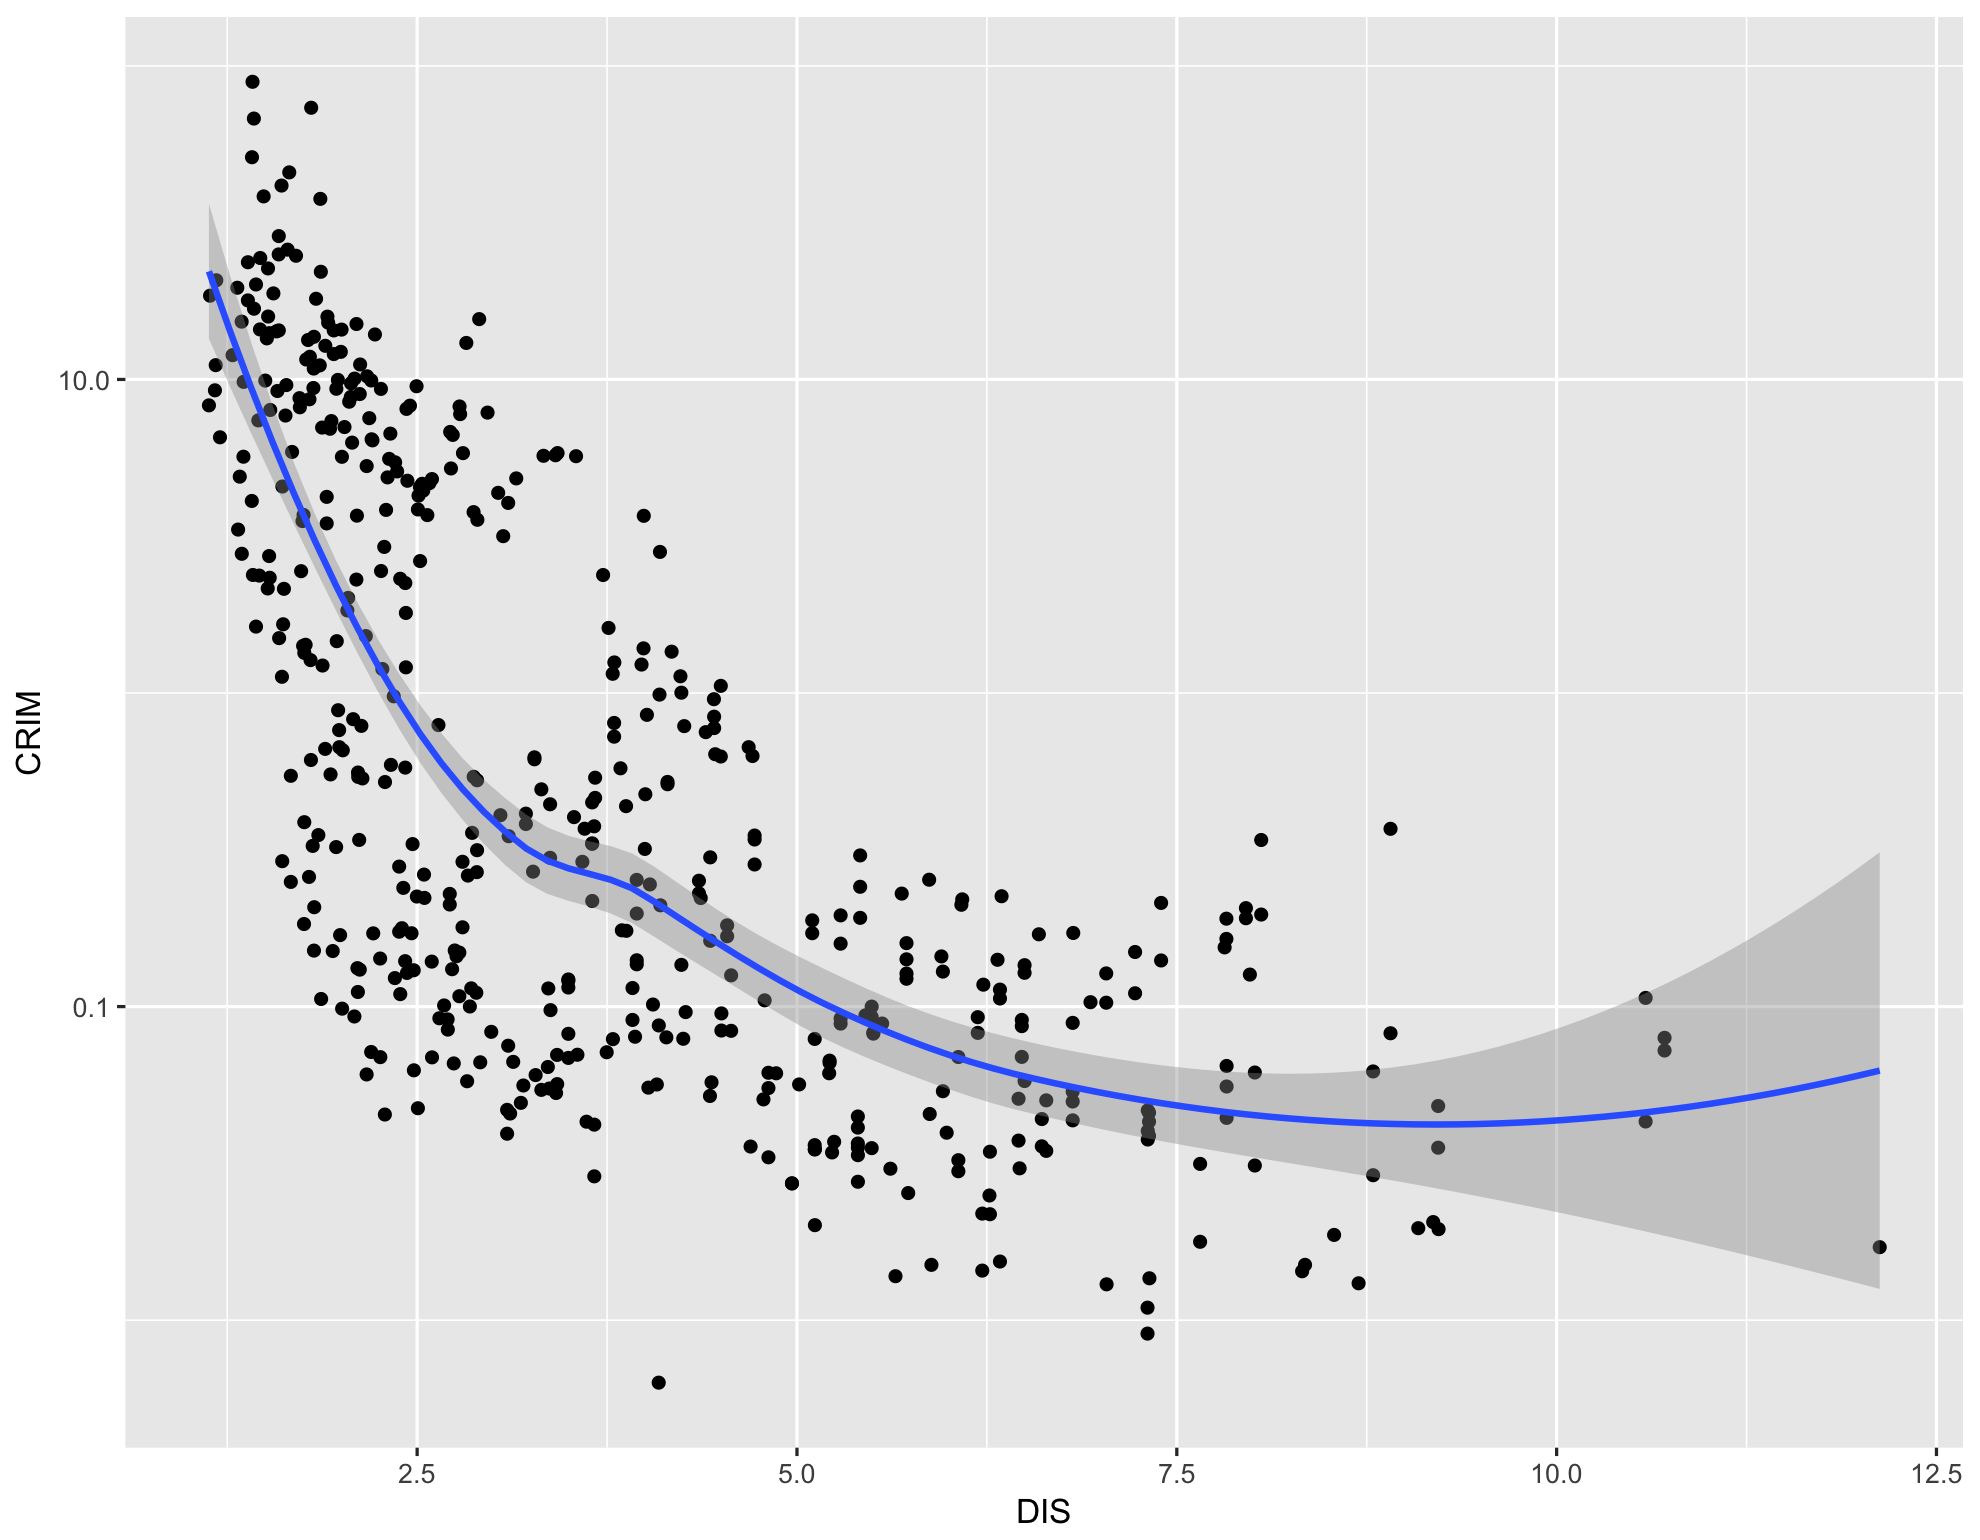

In [4]:
%%R -i df -w 9 -h 7 -u in -r 220

library(ggplot2)

ggplot(df, aes(x = DIS, y = CRIM)) + 
    geom_point() +
    geom_smooth(method = 'loess') +
    scale_y_log10()

Wow, it looks like we found a significant relationship between the distance to employment areas and the crime rate. And, this does make intuitive sense, since the the high employment areas of any city tend to be in the more densely populated urban centers that also tend to have higher crime rates. So, the further we move away from these areas, and into the suburbs, the faster the crime rate declines. 

Well, the visualization speaks volumes, but we can go a step further and actually pull the model that was created in the previous visualization back into python. The `geom_smooth` operation uses the `loess` function to perform its regression, so we can simply run that function ourselves to capture the model using the inline version of the `rpy2` magics command. Another option would have been to use the `-o` parameter to specify the R objects that we want to pass back to Python.

In [5]:
model = %R -i df loess(log(CRIM) ~ DIS, df)
print(model)

Call:
loess(formula = log(CRIM) ~ DIS, data = df)

Number of Observations: 506 
Equivalent Number of Parameters: 4.9 
Residual Standard Error: 1.413 

